
# Limites de classificação de plotagem com diferentes kernels SVM
Este exemplo mostra como diferentes kernels em um :class:`~sklearn.svm.SVC` (Classificador de Vetores de Suporte) influenciam os limites de classificação em um problema de classificação binária bidimensional.

Os SVCs visam encontrar um hiperplano que separe efetivamente as classes em seus dados de treinamento, maximizando a margem entre os pontos de dados mais externos de cada classe. Isso é alcançado encontrando o melhor vetor de pesos
que define o hiperplano do limite de decisão e minimiza a soma das perdas de dobradiça para amostras classificadas incorretamente, conforme medido pela função :func:`~sklearn.metrics.hinge_loss` . Por padrão, a regularização é aplicada com o parâmetro  `C=1`, o que permite um certo grau de tolerância a erros de classificação.

Se os dados não forem linearmente separáveis ​​no espaço de características original, um parâmetro de kernel não linear pode ser definido. Dependendo do kernel, o processo envolve adicionar novas características ou transformar características existentes para enriquecer e potencialmente adicionar significado aos dados. Quando um kernel diferente de  `"linear"`  é definido, o SVC aplica o [Truque do kernel](https://en.wikipedia.org/wiki/Kernel_method#Mathematics:_the_kernel_trick)_, que calcula a similaridade entre pares de pontos de dados usando a função kernel sem transformar explicitamente todo o conjunto de dados. O truque do kernel supera a transformação matricial, que de outra forma seria necessária, de todo o conjunto de dados, considerando apenas as relações entre todos os pares de pontos de dados. A função kernel mapeia dois vetores (cada par de observações) para sua similaridade usando seu produto escalar.

O hiperplano pode então ser calculado usando a função kernel como se o conjunto de dados fosse representado em um espaço de dimensão superior. Usar uma função kernel em vez de uma transformação matricial explícita melhora o desempenho, pois a função kernel tem uma complexidade de tempo de $O({n}^2)$, enquanto a transformação matricial é escalonada de acordo com a transformação específica que está sendo aplicada.

Neste exemplo, comparamos os tipos de kernel mais comuns de Máquinas de Vetores de Suporte: o kernel linear  (`"linear"`), o kernel polinomial (`"poly"`), o kernel de função de base radial (`"rbf"`)e o kernel sigmoide  (`"sigmoid"`).


In [ ]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

## Criando um conjunto de dados
Criamos um conjunto de dados de classificação bidimensional com 16 amostras e duas classes. Plotamos as amostras com as cores correspondentes aos seus respectivos alvos.



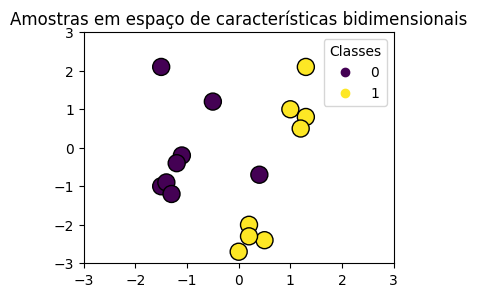

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

X = np.array(
    [
        [0.4, -0.7],
        [-1.5, -1.0],
        [-1.4, -0.9],
        [-1.3, -1.2],
        [-1.1, -0.2],
        [-1.2, -0.4],
        [-0.5, 1.2],
        [-1.5, 2.1],
        [1.0, 1.0],
        [1.3, 0.8],
        [1.2, 0.5],
        [0.2, -2.0],
        [0.5, -2.4],
        [0.2, -2.3],
        [0.0, -2.7],
        [1.3, 2.1],
    ]
)

y = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

# Configurações de plotagem
fig, ax = plt.subplots(figsize=(4, 3))
x_min, x_max, y_min, y_max = -3, 3, -3, 3
ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))

# Plotar amostras por cor e adicionar legenda
scatter = ax.scatter(X[:, 0], X[:, 1], s=150, c=y, label=y, edgecolors="k")
ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
ax.set_title("Amostras em espaço de características bidimensionais")
_ = plt.show()

Podemos observar que as amostras não são claramente separáveis ​​por uma linha reta.

## Treinando o modelo SVC e plotando os limites de decisão
Definimos uma função que se ajusta a um classificador :class:`~sklearn.svm.SVC` ,
permitindo o parâmetro `kernel` como entrada, e então plotamos os limites de decisão
aprendidos pelo modelo usando
:class:`~sklearn.inspection.DecisionBoundaryDisplay`.

Observe que, por uma questão de simplicidade, o parâmetro `C` é definido com seu
valor padrão (`C=1`) neste exemplo e o parâmetro `gamma` é definido como
`gamma=2` em todos os kernels, embora seja automaticamente ignorado para o
kernel linear. Em uma tarefa de classificação real, onde o desempenho importa,
o ajuste de parâmetros (usando :class:`~sklearn.model_selection.GridSearchCV`, por
exemplo) é altamente recomendado para capturar diferentes estruturas dentro dos
dados.

Definir `response_method="predict"` em
:class:`~sklearn.inspection.DecisionBoundaryDisplay` colore as áreas com base
em sua classe prevista. Usar `response_method="decision_function"` nos permite
também plotar o limite de decisão e as margens em ambos os lados dele.
Finalmente, os vetores de suporte usados ​​durante o treinamento (que sempre ficam nas
margens) são identificados por meio do atributo `support_vectors_` dos SVCs
treinados e também plotados.



In [ ]:
from sklearn import svm
from sklearn.inspection import DecisionBoundaryDisplay


def plot_training_data_with_decision_boundary(
    kernel, ax=None, long_title=True, support_vectors=True
):
    # Treinando o SVC
    clf = svm.SVC(kernel=kernel, gamma=2).fit(X, y)

    # Configurações para plotagem
    if ax is None:
        _, ax = plt.subplots(figsize=(4, 3))
    x_min, x_max, y_min, y_max = -3, 3, -3, 3
    ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))

    # Limite e margens de decisão do gráfico
    common_params = {"estimator": clf, "X": X, "ax": ax}
    DecisionBoundaryDisplay.from_estimator(
        **common_params,
        response_method="predict",
        plot_method="pcolormesh",
        alpha=0.3,
    )
    DecisionBoundaryDisplay.from_estimator(
        **common_params,
        response_method="decision_function",
        plot_method="contour",
        levels=[-1, 0, 1],
        colors=["k", "k", "k"],
        linestyles=["--", "-", "--"],
    )

    if support_vectors:
        # Trace círculos maiores em torno de amostras que servem como vetores de suporte
        ax.scatter(
            clf.support_vectors_[:, 0],
            clf.support_vectors_[:, 1],
            s=150,
            facecolors="none",
            edgecolors="k",
        )

    # Plotar amostras por cor e adicionar legenda
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, edgecolors="k")
    ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
    if long_title:
        ax.set_title(f" Limites de decisão de {kernel} kernel em SVC")
    else:
        ax.set_title(kernel)

    if ax is None:
        plt.show()

### Kernel linear
O kernel linear é o produto escalar das amostras de entrada:

\begin{align}K(\mathbf{x}_1, \mathbf{x}_2) = \mathbf{x}_1^\top \mathbf{x}_2\end{align}

Em seguida, ele é aplicado a qualquer combinação de dois pontos de dados (amostras) no
conjunto de dados. O produto escalar dos dois pontos determina a
:func:`~sklearn.metrics.pairwise.cosine_similarity` entre ambos os pontos. Quanto
maior o valor, mais semelhantes os pontos são.



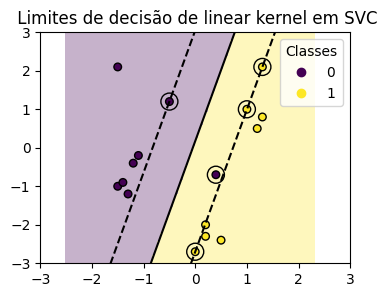

In [ ]:
plot_training_data_with_decision_boundary("linear")

Treinar uma :class:`~sklearn.svm.SVC` em um kernel linear resulta em um
espaço de características não transformado, onde o hiperplano e as margens são
linhas retas. Devido à falta de expressividade do kernel linear, as
classes treinadas não capturam perfeitamente os dados de treinamento.

### Kernel polinomial
O kernel polinomial altera a noção de similaridade. A função kernel
é definida como:

\begin{align}K(\mathbf{x}_1, \mathbf{x}_2) = (\gamma \cdot \
      \mathbf{x}_1^\top\mathbf{x}_2 + r)^d\end{align}

onde ${d}$ é o grau (`degree`) do polinômio, ${\gamma}$
(`gamma`) controla a influência de cada amostra de treinamento individual no
limite de decisão e ${r}$ é o termo de viés (`coef0`) que desloca os
dados para cima ou para baixo. Aqui, usamos o valor padrão para o grau do
polinômio na função kernel (`degree=3`). Quando `coef0=0` (o padrão),
os dados são apenas transformados, mas nenhuma dimensão adicional é adicionada. Usar um
kernel polinomial é equivalente a criar
:class:`~sklearn.preprocessing.PolynomialFeatures` e então ajustar um
:class:`~sklearn.svm.SVC` com um kernel linear nos dados transformados,
embora essa abordagem alternativa seja computacionalmente dispendiosa para a maioria dos
conjuntos de dados.



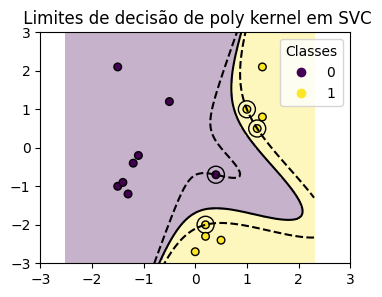

In [ ]:
plot_training_data_with_decision_boundary("poly")

O kernel polinomial com `gamma=2` se adapta bem aos dados de treinamento,
fazendo com que as margens em ambos os lados do hiperplano se curvem de acordo.

### Kernel RBF
O kernel da função de base radial (RBF), também conhecido como kernel Gaussiano, é
o kernel padrão para Máquinas de Vetores de Suporte no scikit-learn. Ele mede
a similaridade entre dois pontos de dados em dimensões infinitas e, em seguida, se aproxima
da classificação por maioria de votos. A função kernel é definida como:

\begin{align}K(\mathbf{x}_1, \mathbf{x}_2) = \exp\left(-\gamma \cdot
      {\|\mathbf{x}_1 - \mathbf{x}_2\|^2}\right)\end{align}

onde ${\gamma}$ (`gamma`) controla a influência de cada
amostra de treinamento individual na fronteira de decisão.

Quanto maior a distância euclidiana entre dois pontos
$\|\mathbf{x}_1 - \mathbf{x}_2\|^2$
mais próxima de zero a função kernel. Isso significa que dois pontos distantes
têm maior probabilidade de serem diferentes.



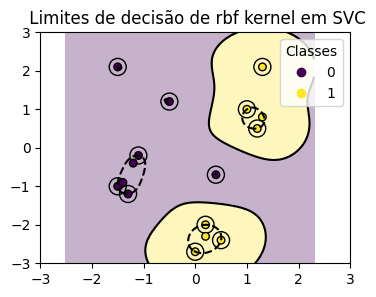

In [ ]:
plot_training_data_with_decision_boundary("rbf")

No gráfico, podemos ver como os limites de decisão tendem a se contrair em torno de
pontos de dados próximos uns dos outros.

### Núcleo sigmoide
A função do núcleo sigmoide é definida como:

\begin{align}K(\mathbf{x}_1, \mathbf{x}_2) = \tanh(\gamma \cdot
      \mathbf{x}_1^\top\mathbf{x}_2 + r)\end{align}

onde o coeficiente do kernel ${\gamma}$ (`gamma`) controla a influência
de cada amostra de treinamento individual na fronteira de decisão e ${r}$ é
o termo de viés (`coef0`) que desloca os dados para cima ou para baixo.

No kernel sigmoide, a similaridade entre dois pontos de dados é calculada
usando a função tangente hiperbólica ($\tanh$). A função do kernel
dimensiona e possivelmente desloca o produto escalar dos dois pontos
($\mathbf{x}_1$ e $\mathbf{x}_2$).



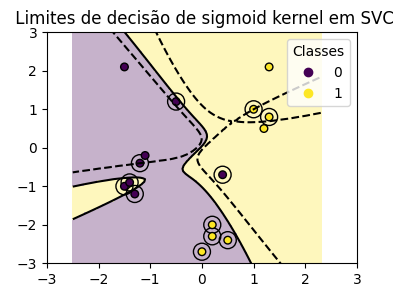

In [ ]:
plot_training_data_with_decision_boundary("sigmoid")

Podemos observar que os limites de decisão obtidos com o kernel sigmoide
parecem curvos e irregulares. O limite de decisão tenta separar as
classes ajustando uma curva em forma de sigmoide, resultando em um limite complexo
que pode não ser bem generalizável para dados não observados. A partir deste exemplo, torna-se
óbvio que o kernel sigmoide tem casos de uso muito específicos ao lidar
com dados que exibem uma forma sigmoide. Neste exemplo, um ajuste fino
cuidadoso pode encontrar limites de decisão mais generalizáveis. Devido à sua
especificidade, o kernel sigmoide é menos comumente usado na prática em comparação com
outros kernels.

## Conclusão
Neste exemplo, visualizamos os limites de decisão treinados com o
conjunto de dados fornecido. Os gráficos servem como uma demonstração intuitiva de como
diferentes kernels utilizam os dados de treinamento para determinar os limites
de classificação.

Os hiperplanos e margens, embora calculados indiretamente, podem ser imaginados como
planos no espaço de características transformado. No entanto, nos gráficos, eles são
representados em relação ao espaço de características original, resultando em limites de decisão
curvos para os kernels polinomial, RBF e sigmoide.

Observe que os gráficos não avaliam a precisão ou
qualidade do kernel individual. Eles visam fornecer uma compreensão visual de como os
diferentes kernels usam os dados de treinamento.

Para uma avaliação abrangente, recomenda-se o ajuste fino dos parâmetros :class:`~sklearn.svm.SVC`
usando técnicas como
:class:`~sklearn.model_selection.GridSearchCV` para capturar as
estruturas subjacentes nos dados.


## Conjunto de dados XOR
Um exemplo clássico de um conjunto de dados que não é linearmente separável é o padrão XOR.
Aqui, demonstramos como diferentes kernels funcionam em tal conjunto de dados.


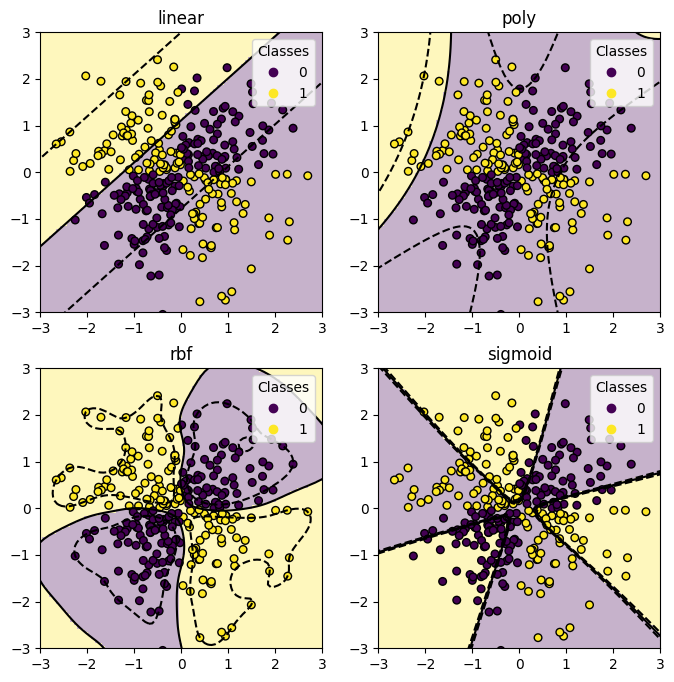

In [ ]:
xx, yy = np.meshgrid(np.linspace(-3, 3, 500), np.linspace(-3, 3, 500))
np.random.seed(0)
X = np.random.randn(300, 2)
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)

_, ax = plt.subplots(2, 2, figsize=(8, 8))
args = dict(long_title=False, support_vectors=False)
plot_training_data_with_decision_boundary("linear", ax[0, 0], **args)
plot_training_data_with_decision_boundary("poly", ax[0, 1], **args)
plot_training_data_with_decision_boundary("rbf", ax[1, 0], **args)
plot_training_data_with_decision_boundary("sigmoid", ax[1, 1], **args)
plt.show()

Como você pode ver nos gráficos acima, somente o kernel `rbf` pode encontrar um
limite de decisão razoável para o conjunto de dados acima.

#Tarefa

Tente replicar esta classificação com o RVM (use o pacote sklearn-rvm)



# Task Response

Nesta seção estará disponível o código resposta da tarefa proposta

# Conceitual

## O que é o RVM

RVM é a sigla para o classificador relevance vector machines, em portugês, máquinas de vetores de relevância, veja (https://sklearn-rvm.readthedocs.io/en/latest/introduction.html).

# Passo 1
## Conjunto de Dados

Para o código usando RVM será utilizada a mesma base de dados do código exemplo acima (SVM).

Para efeitos informativos o código que gera o conjunto de dados será escrito novamente abaixo.

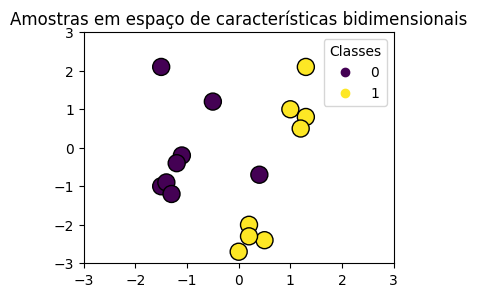

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

X = np.array(
    [
        [0.4, -0.7],
        [-1.5, -1.0],
        [-1.4, -0.9],
        [-1.3, -1.2],
        [-1.1, -0.2],
        [-1.2, -0.4],
        [-0.5, 1.2],
        [-1.5, 2.1],
        [1.0, 1.0],
        [1.3, 0.8],
        [1.2, 0.5],
        [0.2, -2.0],
        [0.5, -2.4],
        [0.2, -2.3],
        [0.0, -2.7],
        [1.3, 2.1],
    ]
)

y = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

# Configurações de plotagem
fig, ax = plt.subplots(figsize=(4, 3))
x_min, x_max, y_min, y_max = -3, 3, -3, 3
ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))

# Plotar amostras por cor e adicionar legenda
scatter = ax.scatter(X[:, 0], X[:, 1], s=150, c=y, label=y, edgecolors="k")
ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
ax.set_title("Amostras em espaço de características bidimensionais")
_ = plt.show()

# Passo 2
## Instalar o RVM

Para treinar o classificador RVM primeiramente deve-se instalar a biblioteca abaixo.:

In [ ]:
!pip install -U sklearn-rvm

# Passo 3
## Treinando o modelo RVM utilizando os kernels

## Imports necessários para o treinamento



In [ ]:
from sklearn_rvm import EMRVC

In [ ]:
def plot_training_data_with_decision_boundary_rvm(
    kernel, ax=None, long_title=True, relevance_vectors=True
):
  if kernel == "linear":
    clf = EMRVC(kernel=kernel).fit(X, y)
  else:
    clf = EMRVC(kernel=kernel, gamma=2).fit(X, y)

  if ax is None:
    _, ax = plt.subplots(figsize=(4, 3))
  x_min, x_max, y_min, y_max = -3, 3, -3, 3
  ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))

  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
  Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)

  contour = ax.contourf(xx, yy, Z, levels=np.linspace(0, 1, 10), cmap=plt.cm.RdBu, alpha=0.8)
  ax.contour(xx, yy, Z, levels=[0.5], colors='k', linestyles='-')

  if relevance_vectors:
    ax.scatter(
            clf.relevance_vectors_[:, 0],
            clf.relevance_vectors_[:, 1],
            s=250, # Tamanho maior para destacar
            facecolors="none",
            edgecolors="blue", # Cor diferente para diferenciar de SVM support vectors
            label="Relevance Vectors" # Adicionar legenda para vetores de relevância
        )
    ax.legend(loc="upper right", title="Elementos")

  ax.scatter(X[:, 0], X[:, 1], c=y, s=30, edgecolors="k")

  if long_title:
    ax.set_title(f"Limites de decisão de {kernel} kernel em RVC")
  else:
    ax.set_title(kernel)

  if ax is None: # Se não for parte de um subplot, exiba individualmente
    plt.show()

## Kernel RFB

Seguindo com a função, no modelo proposto com SVM

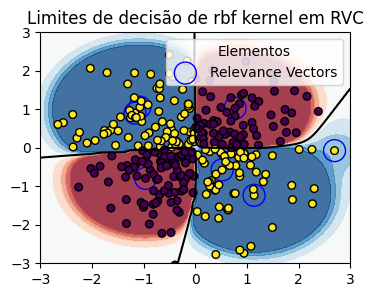

In [ ]:
plot_training_data_with_decision_boundary_rvm("rbf")
plt.show()

Modelo seguindo a documentação

Automatically created module for IPython interactive environment


/usr/local/lib/python3.11/dist-packages/sklearn_rvm/em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will change "


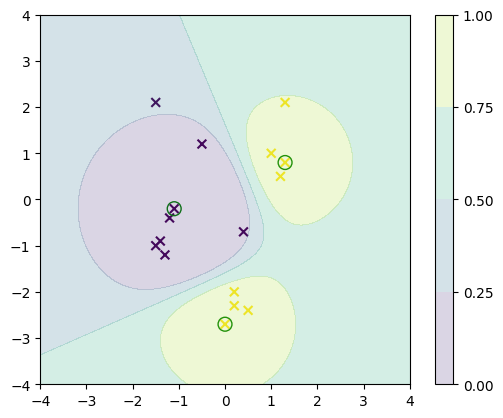

In [ ]:
# exemplo seguindo a documentação
print(__doc__)

model = EMRVC(kernel="rbf").fit(X, y)

x0, x1 = np.meshgrid(np.linspace(-4, 4, 100), np.linspace(-4, 4, 100))
x = np.array([x0, x1]).reshape(2, -1).T
plt.scatter(X[:, 0], X[:, 1], s=40, c=y, marker="x")
plt.scatter(model.relevance_vectors_[:, 0], model.relevance_vectors_[:, 1], s=100, facecolor="none", edgecolor="g")
plt.contourf(x0, x1, model.predict_proba(x)[:, 1].reshape(100, 100), np.linspace(0, 1, 5), alpha=0.2)
plt.colorbar()
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.gca().set_aspect("equal", adjustable="box")

## Kernel Polinomial

Seguindo com a função, no modelo proposto com SVM

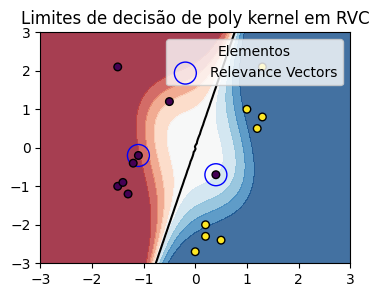

In [ ]:
plot_training_data_with_decision_boundary_rvm("poly")
plt.show()

Modelo seguindo a documentação

Automatically created module for IPython interactive environment


/usr/local/lib/python3.11/dist-packages/sklearn_rvm/em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will change "


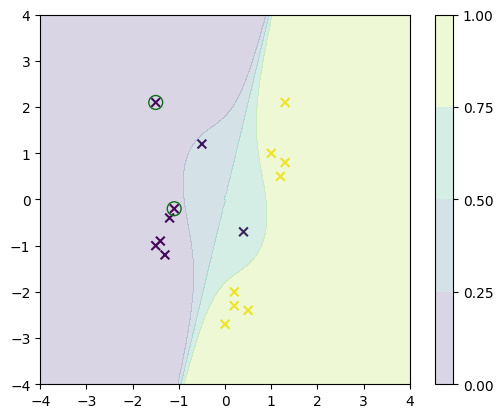

In [ ]:
# exemplo seguindo a documentação
print(__doc__)

model = EMRVC(kernel="poly").fit(X, y)

x0, x1 = np.meshgrid(np.linspace(-4, 4, 100), np.linspace(-4, 4, 100))
x = np.array([x0, x1]).reshape(2, -1).T
plt.scatter(X[:, 0], X[:, 1], s=40, c=y, marker="x")
plt.scatter(model.relevance_vectors_[:, 0], model.relevance_vectors_[:, 1], s=100, facecolor="none", edgecolor="g")
plt.contourf(x0, x1, model.predict_proba(x)[:, 1].reshape(100, 100), np.linspace(0, 1, 5), alpha=0.2)
plt.colorbar()
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.gca().set_aspect("equal", adjustable="box")

## Kernel Linear

Seguindo com a função, no modelo proposto com SVM

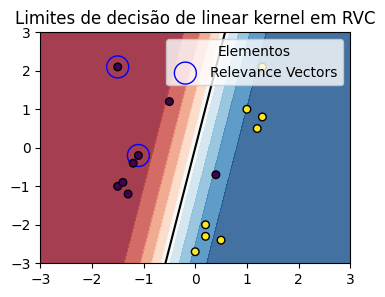

In [ ]:
plot_training_data_with_decision_boundary_rvm("linear")
plt.show()

Modelo seguindo a documentação

Automatically created module for IPython interactive environment


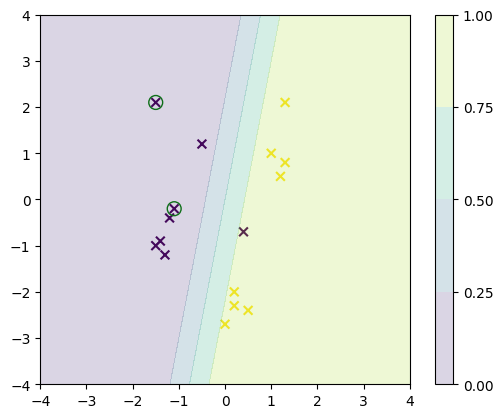

In [ ]:
# exemplo seguindo a documentação
print(__doc__)

model = EMRVC(kernel="linear").fit(X, y)

x0, x1 = np.meshgrid(np.linspace(-4, 4, 100), np.linspace(-4, 4, 100))
x = np.array([x0, x1]).reshape(2, -1).T
plt.scatter(X[:, 0], X[:, 1], s=40, c=y, marker="x")
plt.scatter(model.relevance_vectors_[:, 0], model.relevance_vectors_[:, 1], s=100, facecolor="none", edgecolor="g")
plt.contourf(x0, x1, model.predict_proba(x)[:, 1].reshape(100, 100), np.linspace(0, 1, 5), alpha=0.2)
plt.colorbar()
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.gca().set_aspect("equal", adjustable="box")

## Kernel Sigmoid

Seguindo com a função, no modelo proposto com SVM

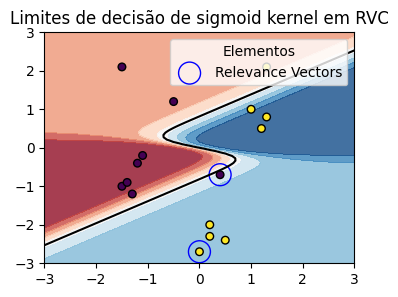

In [ ]:
plot_training_data_with_decision_boundary_rvm("sigmoid")
plt.show()

Modelo seguindo a documentação

Automatically created module for IPython interactive environment


/usr/local/lib/python3.11/dist-packages/sklearn_rvm/em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will change "


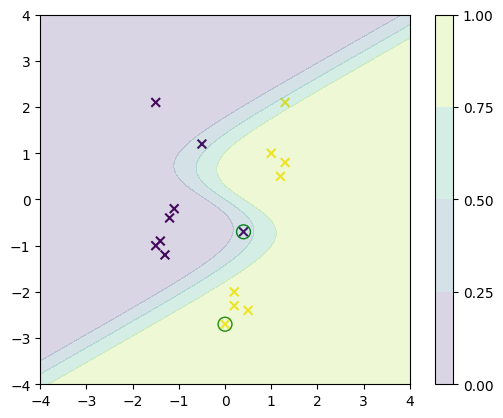

In [ ]:
# exemplo seguindo a documentação
print(__doc__)

model = EMRVC(kernel="sigmoid").fit(X, y)

x0, x1 = np.meshgrid(np.linspace(-4, 4, 100), np.linspace(-4, 4, 100))
x = np.array([x0, x1]).reshape(2, -1).T
plt.scatter(X[:, 0], X[:, 1], s=40, c=y, marker="x")
plt.scatter(model.relevance_vectors_[:, 0], model.relevance_vectors_[:, 1], s=100, facecolor="none", edgecolor="g")
plt.contourf(x0, x1, model.predict_proba(x)[:, 1].reshape(100, 100), np.linspace(0, 1, 5), alpha=0.2)
plt.colorbar()
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.gca().set_aspect("equal", adjustable="box")

# Conjunto de dados XOR

Seguindo com a função, no modelo proposto com SVM

In [ ]:
# Função para treinar e plotar RVM para um kernel dado
def plot_rvm_decision_boundary(kernel, ax):
    model = EMRVC(kernel=kernel).fit(X, y)
    Z_prob = model.predict_proba(grid)[:, 1].reshape(x0.shape)

    # Plotar contorno probabilístico (limite de decisão "suave")
    cont = ax.contourf(x0, x1, Z_prob, levels=np.linspace(0, 1, 20), cmap="coolwarm", alpha=0.3)
    plt.colorbar(cont, ax=ax)

    # Plotar pontos de dados
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors="k", s=30)

    # Plotar vetores relevantes
    ax.scatter(model.relevance_vectors_[:, 0], model.relevance_vectors_[:, 1],
               s=100, facecolors="none", edgecolors="g", label="Vetores relevantes")

    ax.set_title(f"Kernel: {kernel}")
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    ax.set_aspect("equal", adjustable="box")
    ax.legend()

/usr/local/lib/python3.11/dist-packages/sklearn_rvm/em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will change "
/usr/local/lib/python3.11/dist-packages/sklearn_rvm/em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will change "
/usr/local/lib/python3.11/dist-packages/sklearn_rvm/em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will change "


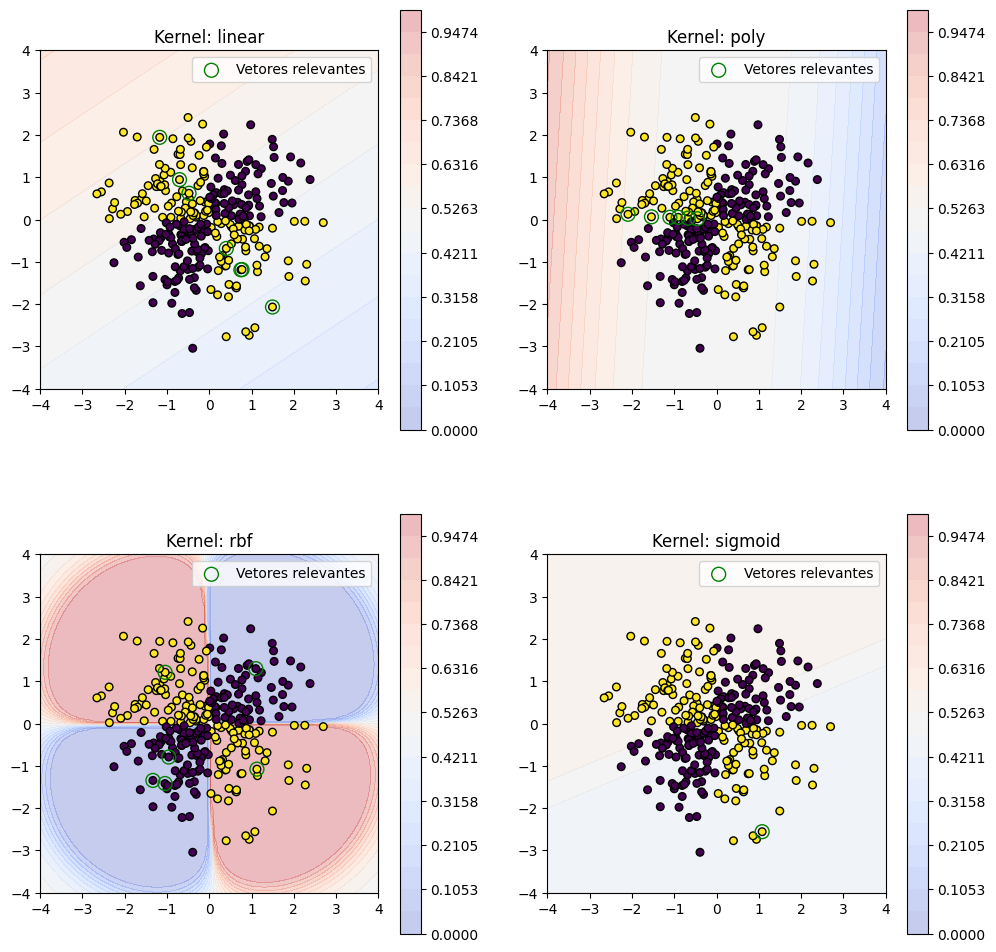

In [ ]:
# Gerar dados XOR
np.random.seed(0)
X = np.random.randn(300, 2)
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0).astype(int)

# Definir grid para plotagem
x0, x1 = np.meshgrid(np.linspace(-4, 4, 100), np.linspace(-4, 4, 100))
grid = np.array([x0.ravel(), x1.ravel()]).T

# Criar figura com 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

kernels = ["linear", "poly", "rbf", "sigmoid"]

for ax, kernel in zip(axs.ravel(), kernels):
    plot_rvm_decision_boundary(kernel, ax)

plt.show()
